# Toxic Comment Classification

## Load Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as pylab
import seaborn as sns

import re
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GlobalAveragePooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint 
from keras.models import Sequential

Using TensorFlow backend.


## Load Data & Basic EDA

In [2]:
# Word Embeddings
glove_path = 'datasets/glove.6B.50d.txt'

In [3]:
# List Classfier
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [4]:
# Read Train Data
train_df = pd.read_csv("datasets/train.csv")
train_df.dropna(inplace=True)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
# Read Test Data
test_df = pd.read_csv("datasets/test.csv")
test_df.dropna(inplace=True)
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [6]:
# Read Test Label Data
test_labels_df = pd.read_csv("datasets/test_labels.csv")
test_labels_df.dropna(inplace=True)
test_labels_df.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [7]:
#(pd.isnull(train_df).sum())
train_df.count()

id               159571
comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
dtype: int64

In [8]:
# Double check if test_df and test_labels_df got the same number of rows of dataset
test_df["id"].count() == test_labels_df["id"].count()

True

In [9]:
# Check a comment BEFORE standardising the contractions and removal of stopwords
train_df['comment_text'][77]

"In the same direction, is it really necessary to name all the US states who recognize it? Why not give just the number of states? This is not an American encyclopedia, but an universal one, I don't see why every single US states which recognize it should be named.  (ix)"

In [10]:
# Standardise contractions to standard english word
# Removal of stopwords
# eg: can't OR cant --> cannot
for dataset in [train_df, test_df]:
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('\'ll', ' will'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('\'ve', ' have'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('don\'t', ' do not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('dont', ' do not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('aren\'t', ' are not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('won\'t', ' will not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('wont', ' will not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('can\'t', ' cannot'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('cant', ' cannot'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('shan\'t', ' shall not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('shant', ' shall not'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace('\'m', ' am'))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("doesn't", "does not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("doesnt", "does not"))                                                      
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace( "didn't", "did not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace( "didnt", "did not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("hasn't", "has not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("hasnt", "has not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("haven't", "have not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("havent", "have not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("wouldn't", "would not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace( "didn't", "did not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace( "didnt", "did not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("it's" , "it is"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace( "that's" , "that is"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("weren't" , "were not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace("werent" , "were not"))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace(' u ', ' you '))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x.replace(' U ', ' you '))
    dataset['comment_text'] = dataset['comment_text'].apply(lambda x: re.sub('[\(\)\"\t_\n.,:=!@#$%^&*-/[\]?|1234567890—]', ' ', x).strip())

In [11]:
# Check a comment AFTER standardising the contractions and removal of stopwords
train_df['comment_text'][77]

'In the same direction  is it really necessary to name all the US states who recognize it  Why not give just the number of states  This is not an American encyclopedia  but an universal one  I  do not see why every single US states which recognize it should be named    ix'

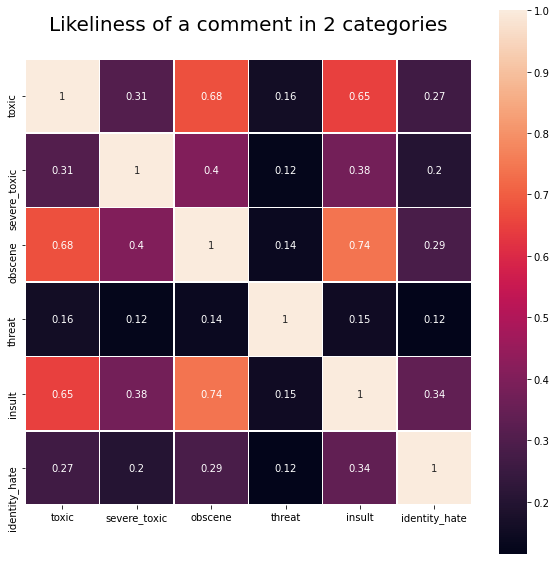

In [12]:
# Heatmap to see the likeliness of a comment falling into 2 categories
plt.figure(figsize=(10,10))
plt.title('Likeliness of a comment in 2 categories',y=1.05,size=20)
sns.heatmap(train_df[list_classes].astype(float).corr(),linewidths=0.5,vmax=1.0,square=True,annot=True)
plt.show()

In [13]:
MAX_FEATURES = 20000
MAX_LENGTH = 100
EMBED_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 5

## Tokenizing data

In [14]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_df['comment_text'])

In [15]:
train_tokenized = tokenizer.texts_to_sequences(train_df['comment_text'])
test_tokenized = tokenizer.texts_to_sequences(test_df['comment_text'])

In [16]:
X_train = pad_sequences(train_tokenized, maxlen=MAX_LENGTH)
X_test = pad_sequences(test_tokenized, maxlen=MAX_LENGTH)
Y = train_df[list_classes]

## Embedding Matrix

In [17]:
embedding_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        embedding_index[values[0]] = np.asarray(values[1:], dtype='float32')

word_index = tokenizer.word_index
num_words = min(MAX_FEATURES, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBED_SIZE))
for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue

    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Build the model

In [18]:
model = Sequential([
    Embedding(MAX_FEATURES, EMBED_SIZE),
    Bidirectional(LSTM(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1)),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(64,activation='relu'),
    Dropout(0.1),
    Dense(6,activation="sigmoid")
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [20]:
csv_logger = CSVLogger('log.csv', append=True, separator=',')
checkpoint = ModelCheckpoint('checkpoint.csv', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
models = model.fit(X_train, Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1,
                   callbacks=[csv_logger, reduce_lr, checkpoint])

C:\Users\ValuedAcerCustomer\.conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 595s 4ms/step - loss: 0.0660 - accuracy: 0.9785 - val_loss: 0.0508 - val_accuracy: 0.9817
Epoch 2/5
    32/143613 [..............................] - ETA: 10:19 - loss: 0.0777 - accuracy: 0.9740

C:\Users\ValuedAcerCustomer\.conda\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


143613/143613 [==============================] - 586s 4ms/step - loss: 0.0472 - accuracy: 0.9825 - val_loss: 0.0513 - val_accuracy: 0.9818
Epoch 3/5
143613/143613 [==============================] - 584s 4ms/step - loss: 0.0409 - accuracy: 0.9844 - val_loss: 0.0499 - val_accuracy: 0.9825
Epoch 4/5
143613/143613 [==============================] - 616s 4ms/step - loss: 0.0392 - accuracy: 0.9849 - val_loss: 0.0503 - val_accuracy: 0.9824
Epoch 5/5
143613/143613 [==============================] - 609s 4ms/step - loss: 0.0372 - accuracy: 0.9856 - val_loss: 0.0506 - val_accuracy: 0.9824


In [27]:
#model.load_weights('checkpoint.csv')
sub = model.predict(X_test)
temp = pd.read_csv('datasets/sample_submission.csv')
temp[list_classes] = sub
temp.to_csv('datasets/submission.csv', index=False)